# Notebook to calculate $P_\times(k_\parallel,r_\perp)$ and $P_{1D}(k_\parallel)$

## Import the necessary libraies

In [1]:
import h5py
import numpy as np
import os
from matplotlib import pyplot as plt
import re
import pickle
import astrid as st

## Constants to be used along the notebook

In [2]:
save_path = '/data/desi/scratch/jlopez/' # Or the path to save heavy files
L_hMpc = 250 # Side lenght of the simulation box in Mpc/h
Nsk = 500 # Number of skewers per side on the simulation
dxy_hMpc = L_hMpc / Nsk  # Skewer separation (0.5 Mpc/h)
Np = 2500 # Number of pixels of each skewer
dz_hMpc = L_hMpc / Np # Lenght of each pixel (0.1 Mpc/h)
block_grid_size = 5 # Number of blocks in each side (5×5 grid)
n_blocks = block_grid_size ** 2 # Total number of blocks (25)
block_size = Nsk // block_grid_size  # Side lenght of each block (100 Mpc/h)
max_logN_mask = 21.3 # Max column density allowed
r_edges = np.array([0, 0.6, 0.8, 1.2, 1.6])  # Edges of the radial bins in Mpc/h
r_edges_pix = r_edges / dxy_hMpc  # Edges in pixel units
r_bins = 4 # Number of bins
k = 2 * np.pi * np.arange(Np) / L_hMpc # Fourier modes

## Load the data from both simulations

In [3]:
fname_on='/data/desi/common/astrid/spectra_ASTRID_z2.5_500x500x2500.hdf5'
fname_off='/data/desi/common/astrid/spectra_ASTRID_self-shield_off_z2.5_500x500x2500.hdf5'

In [4]:
tau_on, tau_off, colden = st.load_sim(fname_on, fname_off)

## Filter very large column density

In [5]:
tau_on, tau_off = st.apply_zero_filter(tau_on, tau_off, colden, max_logN_mask)

## Extract the different fields

In [6]:
tau_tot, tau_lya, tau_hcd = st.fields(tau_on, tau_off, L_hMpc, Np)

## Break down the simulation into 25 boxes

In [7]:
tau_tot, tau_lya, tau_hcd = st.divbox(tau_tot, tau_lya, tau_hcd, Nsk, Np, block_grid_size, block_size)

## Compute constant C

In [9]:
C = st.compute_C(tau_tot, tau_lya, tau_hcd, block_grid_size)

## Compute $P_\times$ and $P_{1D}$ in each box

In [ ]:
Px_all = st.compute_px(tau_tot, tau_lya, tau_hcd, L_hMpc, Np, block_grid_size, r_edges, Nsk)

In [ ]:
P1D_all = st.compute_p1d(tau_tot, tau_lya, tau_hcd, L_hMpc, Np, block_grid_size)

## Save results

In [ ]:
st.save_power_spectra(P1D_all, Px_all, save_path)

In [14]:
np.save(save_path + 'C.npy', C)

## Load results

In [3]:
P1D_all, Px_all = st.load_power_spectra(save_path)

In [4]:
C = np.load(save_path + 'C.npy')

## Compute the mean and standard deviation of $P_\times$ and $P_{1D}$ 

In [5]:
P1D_means, P1D_stds, P1D_model, P1D_model_std = st.avg_std_P1D(P1D_all, block_grid_size, C, Np)

In [6]:
Px_means, Px_stds, Px_model, Px_model_std = st.avg_std_Px(Px_all, block_grid_size, C, Np)

## Plot results

In [53]:
sumasao = sum(Px_means['rbin1'][key] for key in Px_means['rbin1'].keys()) - Px_means['rbin1']['Px_F']
mod = sumasao / (1 + C)**2
dif = np.abs(mod - Px_means['rbin1']['Px_F'])
rel = dif/Px_means['rbin1']['Px_F']
print(max(dif))


0.0077597908996233644


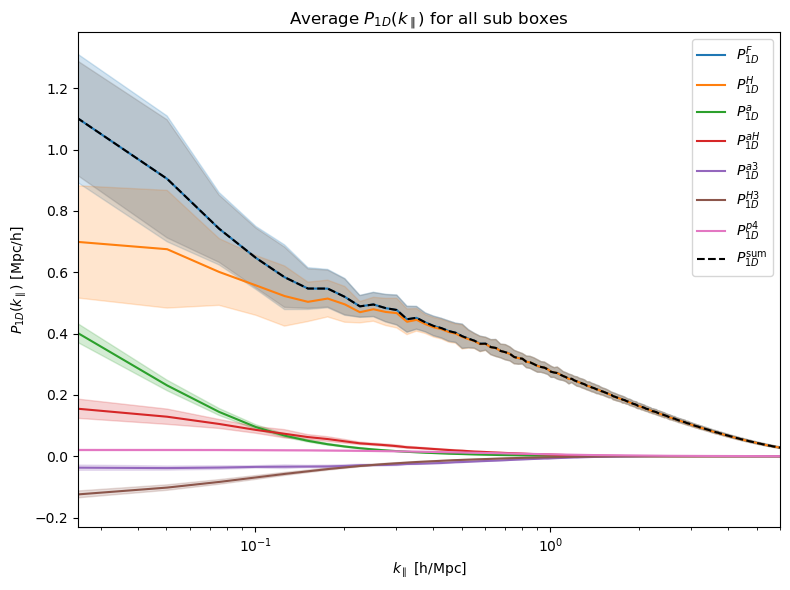

In [41]:
st.plot_all_P1D_with_stds(k, P1D_means, P1D_stds, P1D_model, P1D_model_std, k[1], 6)

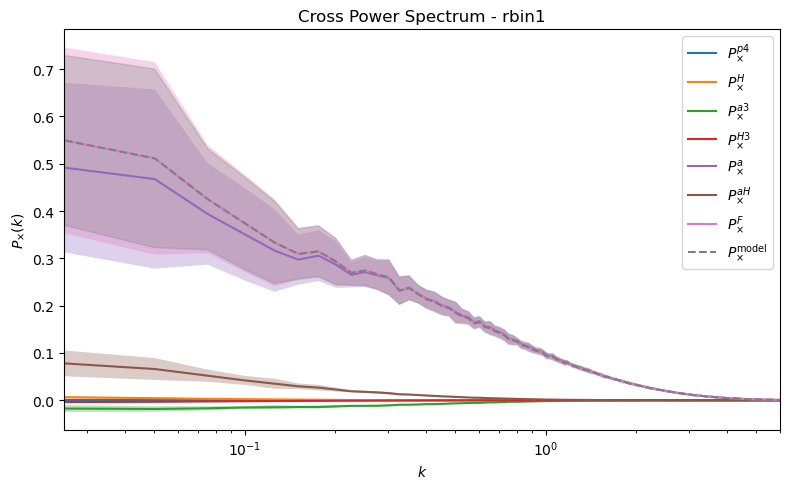

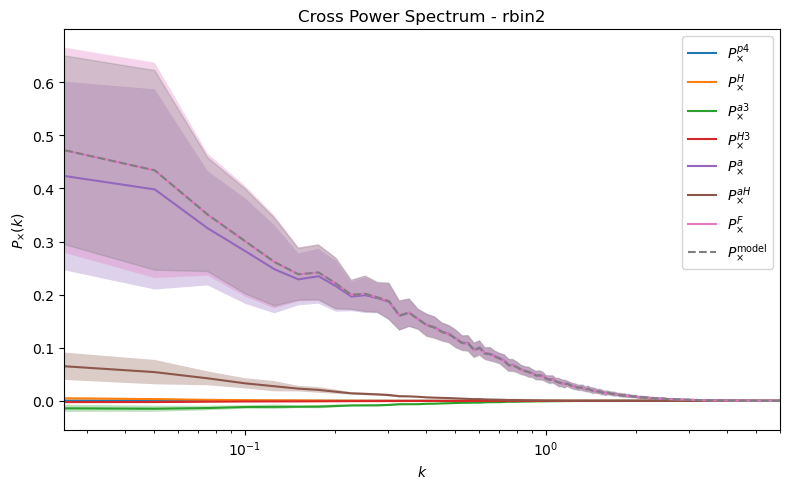

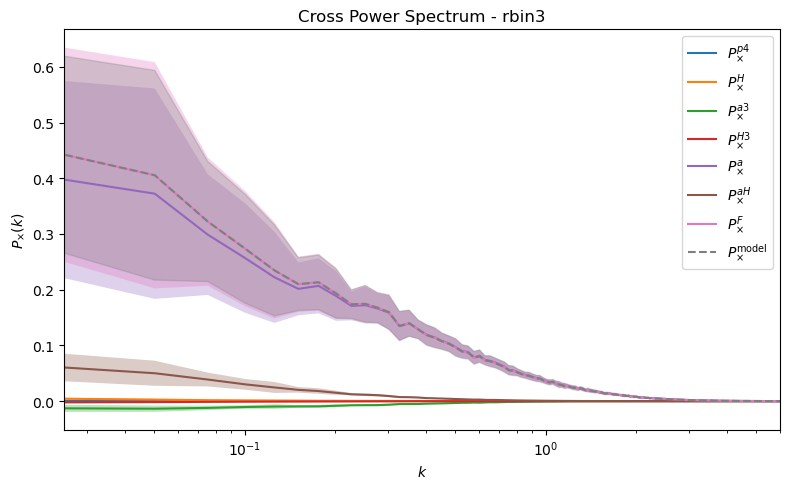

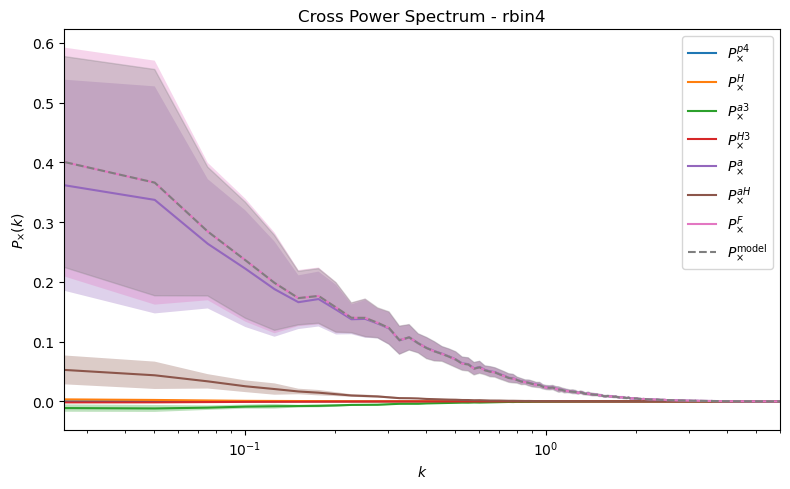

In [8]:
st.plot_Px_per_rbin(Px_means, Px_stds, Px_model, Px_model_std, k)

## Manual plots for testing

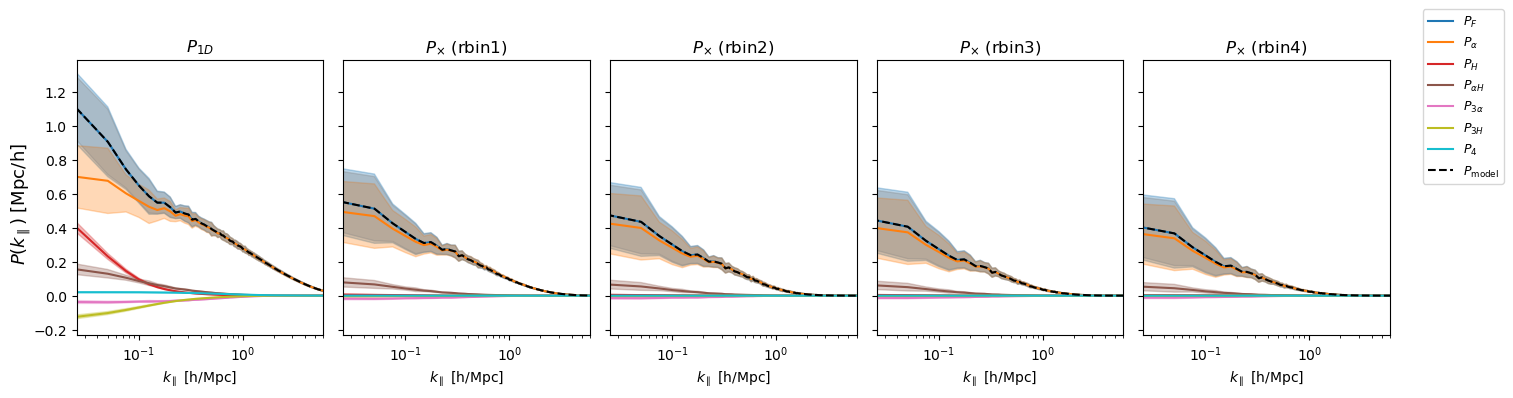

In [25]:
# Use plain keys internally
components = ['F', 'a', 'H', 'aH', 'a3', 'H3', 'p4']

# LaTeX-friendly display labels
label_map = {
    'F': r'$P_F$',
    'a': r'$P_\alpha$',
    'H': r'$P_H$',
    'aH': r'$P_{\alpha H}$',
    'a3': r'$P_{3\alpha}$',
    'H3': r'$P_{3H}$',
    'p4': r'$P_4$',
    'model': r'$P_{\mathrm{model}}$'
}

# Consistent colors
colors = plt.cm.tab10(np.linspace(0, 1, len(components)))
color_map = {comp: color for comp, color in zip(components, colors)}

rbins = sorted(Px_means.keys())
ncols = 1 + len(rbins)

fig, axes = plt.subplots(1, ncols, figsize=(3 * ncols, 4), sharey=True)

# --- For global legend ---
lines_for_legend = []
labels_for_legend = []

# --- Plot P1D ---
ax = axes[0]
for comp in components:
    key = f'P1D_{comp}'
    if key in P1D_means:
        mean = P1D_means[key]
        std = P1D_stds[key]
        color = color_map[comp]
        label = label_map[comp]

        line, = ax.plot(k, mean, color=color)
        ax.fill_between(k, mean - std, mean + std, alpha=0.3, color=color)

        lines_for_legend.append(line)
        labels_for_legend.append(label)

# P1D model
line, = ax.plot(k, P1D_model, '--', color='black')
ax.fill_between(k, P1D_model - P1D_model_std, P1D_model + P1D_model_std, color='gray', alpha=0.3)
lines_for_legend.append(line)
labels_for_legend.append(label_map['model'])

ax.set_title(r'$P_{1D}$')
ax.set_xscale('log')
ax.set_xlim(k[1], 6)
ax.set_xlabel(r'$k_\parallel$ [h/Mpc]')

# --- Plot Px per rbin ---
for i, rbin in enumerate(rbins):
    ax = axes[i + 1]
    for comp in components:
        key = f'Px_{comp}'
        if key in Px_means[rbin]:
            mean = Px_means[rbin][key]
            std = Px_stds[rbin][key]
            color = color_map[comp]

            ax.plot(k, mean, color=color)
            ax.fill_between(k, mean - std, mean + std, alpha=0.3, color=color)

    # Px model
    ax.plot(k, Px_model[rbin], '--', color='black')
    ax.fill_between(k, Px_model[rbin] - Px_model_std[rbin],
                    Px_model[rbin] + Px_model_std[rbin], color='gray', alpha=0.3)

    ax.set_title(rf'$P_{{\times}}$ ({rbin})')
    ax.set_xscale('log')
    ax.set_xlim(k[1], 6)
    ax.set_xlabel(r'$k_\parallel$ [h/Mpc]')

# Shared y-label
fig.supylabel(r'$P(k_\parallel)$ [Mpc/h]', fontsize=13)

# Global legend
fig.legend(lines_for_legend, labels_for_legend, loc='upper right', fontsize=9, bbox_to_anchor=(1.02, 1.0))

plt.tight_layout(rect=[0, 0, 0.95, 0.95])
plt.savefig('power.png', bbox_inches='tight', pad_inches=0.1)
plt.show()